In [1]:
from pathlib import Path

import librosa
import numpy
import pysptk
import pyworld

from become_yukarin.config import create_from_json as create_config
from become_yukarin.data_struct import Wave
from become_yukarin.dataset.dataset import *
from become_yukarin.dataset.utility import MFCCAligner

from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
paths = [
    Path('C:/Users/hihok/dataset/hiho-pause-atr503') / 'atr503-2.wav',
    Path('C:/Users/hihok/dataset/yukari-pause-atr503') / 'yukari-pause-atr-1.wav',
]

wave_file_load1 = WaveFileLoadProcess(
    sample_rate=24000,
    top_db=None,
    pad_second=0,
)
wave_file_load2 = WaveFileLoadProcess(
    sample_rate=24000,
    top_db=None,
    pad_second=0.5,
)
acoustic_feature = AcousticFeatureProcess(
    frame_period=5,
    order=24,
    alpha=pysptk.util.mcepalpha(wave_file_load._sample_rate),
)

In [32]:
w1 = wave_file_load1(paths[0], test=True)
f1 = acoustic_feature(w1, test=True)

w2 = wave_file_load2(paths[1], test=True)
f2 = acoustic_feature(w2, test=True)

In [33]:
aligner = MFCCAligner(f1.mfcc, f2.mfcc)

f0_1, f0_2 = aligner.align(f1.f0, f2.f0)
spectrogram_1, spectrogram_2 = aligner.align(f1.spectrogram, f2.spectrogram)
aperiodicity_1, aperiodicity_2 = aligner.align(f1.aperiodicity, f2.aperiodicity)
mfcc_1, mfcc_2 = aligner.align(f1.mfcc, f2.mfcc)
voiced_1, voiced_2 = aligner.align(f1.voiced, f2.voiced)

f1 = AcousticFeature(
    f0=f0_1,
    spectrogram=spectrogram_1,
    aperiodicity=aperiodicity_1,
    mfcc=mfcc_1,
    voiced=voiced_1,
)
f2 = AcousticFeature(
    f0=f0_2,
    spectrogram=spectrogram_2,
    aperiodicity=aperiodicity_2,
    mfcc=mfcc_2,
    voiced=voiced_2,
)

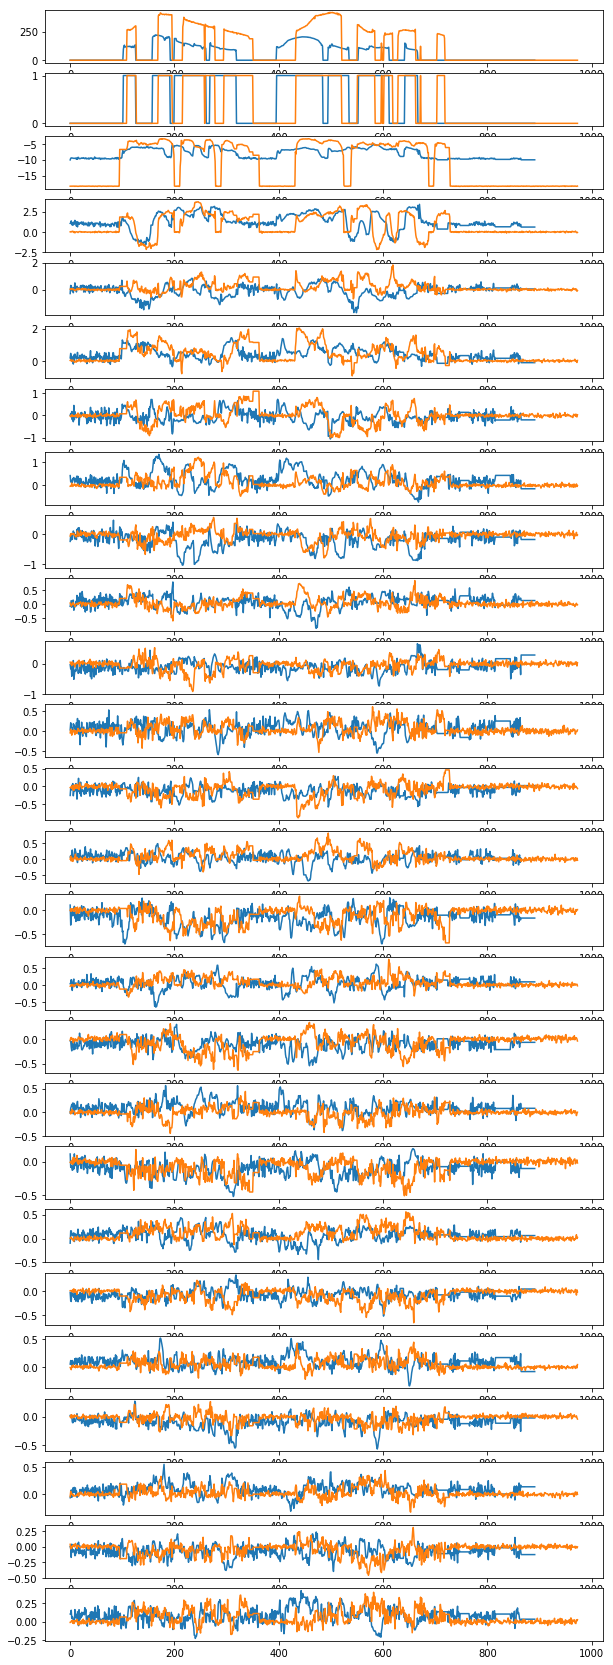

In [34]:
plt.figure(figsize=(10, 30))
ny = 2 + acoustic_feature._order

plt.subplot(ny, 1, 1)
plt.plot(f1.f0)
plt.plot(f2.f0)

plt.subplot(ny, 1, 2)
plt.plot(f1.f0!=0)
plt.plot(f2.f0!=0)

for i in range(acoustic_feature._order):
    plt.subplot(ny, 1, i+3)
    plt.plot(f1.mfcc[:,i])
    plt.plot(f2.mfcc[:,i])

In [35]:
fftlen = pyworld.get_cheaptrick_fft_size(wave_file_load._sample_rate)

spectrogram = pysptk.mc2sp(
    f.mfcc,
    alpha=acoustic_feature._alpha,
    fftlen=fftlen,
)

f = AcousticFeature(
    f0=f.f0,
    spectrogram=spectrogram,
    aperiodicity=f.aperiodicity,
    mfcc=f.mfcc,
    voiced=f.voiced,
).astype(numpy.float64)

out = pyworld.synthesize(
    f0=f.f0.ravel(),
    spectrogram=f.spectrogram,
    aperiodicity=f.aperiodicity,
    fs=wave_file_load._sample_rate,
    frame_period=acoustic_feature._frame_period,
)

Audio(data=out, rate=wave_file_load._sample_rate)

NameError: name 'f' is not defined